# SED fitting with PROSPECTOR

Based on https://prospect.readthedocs.io/en/latest/quickstart.html

## Introduction

"Prospector is a flexible code for inferring stellar population parameters from photometry and spectroscopy spanning UV through IR wavelengths."

"The code works by forward modeling the observed spectrum and photometry of complex stellar populations given a combination of parameters describing that population and instrumental parameters, computing a likelihood and posterior probability for the model based on a noise model and prior distributions, and Monte Carlo sampling the posterior probability distribution." (Johnson+21)

## Import modules and environment variables
This is a notebook that allows you to do SED fitting using known photometry. 
In this case we will proceed with the computed photometry from the previous tutorial given by Tomás.

This notebook Assumes that you already have installed Prospector and its dependencies. If you have issues with that, please contact me.

Important: Set the 'HOME_SPS' variable to your fsps instalation

In [1]:
import os
os.environ['SPS_HOME'] = '/Users/cristinajimenezpalau/fsps'

In [2]:
try:
    import fsps
    import dynesty
    import sedpy
    import h5py, astropy
    import numpy as np
    import astroquery
    from prospect.utils.obsutils import fix_obs
    import sedpy
    from sedpy.observate import list_available_filters
    from astropy.coordinates import SkyCoord
    import astropy.wcs as wcs
    import astropy.units as u
    from astropy.cosmology import FlatLambdaCDM
    import matplotlib.pyplot as plt
    from pylab import rcParams
    from matplotlib import rc
    from prospect.models.templates import TemplateLibrary
    from prospect.models import SpecModel
    import prospect.models
    from prospect.models import priors
    from prospect.sources import CSPSpecBasis
    from prospect.sources import FastStepBasis
    from prospect.likelihood import lnlike_spec, lnlike_phot, write_log
    from prospect.fitting import fit_model
    from prospect.models import PolySpecModel
    import prospect.models
    from prospect.fitting import lnprobfn, fit_model
except RuntimeError:
    print('Remember to set the SPS variable!')

In [6]:
import os
import pandas as pd
from sedpy import observate
import pathlib

import pathlib
fdict=list_available_filters()
print('The available predifined filters are',fdict)

The available predifined filters are ['D4000_blue', 'Halpha', 'Hbeta', 'acs_wfc_f435w', 'acs_wfc_f475w', 'acs_wfc_f555w', 'acs_wfc_f606w', 'acs_wfc_f625w', 'acs_wfc_f775w', 'acs_wfc_f814w', 'acs_wfc_f850lp', 'bessell_B', 'bessell_I', 'bessell_R', 'bessell_U', 'bessell_V', 'cfht_megacam_gs_9401', 'cfht_megacam_is_9701', 'cfht_megacam_rs_9601', 'cfht_megacam_us_9301', 'cfht_megacam_zs_9801', 'cfht_wircam_H_8201', 'cfht_wircam_J_8101', 'cfht_wircam_Ks_8302', 'ctio_mosaic_ii_B', 'ctio_mosaic_ii_Ic', 'ctio_mosaic_ii_Rc', 'ctio_mosaic_ii_Uj', 'ctio_mosaic_ii_V', 'ctio_mosaic_ii_g', 'ctio_mosaic_ii_i', 'ctio_mosaic_ii_r', 'ctio_mosaic_ii_u', 'ctio_mosaic_ii_z', 'decam_Y', 'decam_g', 'decam_i', 'decam_r', 'decam_u', 'decam_z', 'gaia_bp', 'gaia_g', 'gaia_rp', 'galex_FUV', 'galex_NUV', 'herschel_pacs_100', 'herschel_pacs_160', 'herschel_pacs_70', 'herschel_spire_250', 'herschel_spire_350', 'herschel_spire_500', 'hipparcos_B', 'hipparcos_H', 'hipparcos_V', 'hsc_g', 'hsc_i', 'hsc_r', 'hsc_y', 'hsc

## We import the filters and the photometry
First of all we define the filters in different bands for which we have photometry available to compute the SED, obtained by HOSTPHOT.
PROSPECTOR has already built in a lot of filters (using the package sedpy). 
Since PS1 filters are not predefined (we can't load them automatically) we will have to add them manually, using the .par files. 

In [3]:
import os
import pandas as pd
from sedpy import observate
import pathlib

target='SN2006gz'
path='/Users/cristinajimenezpalau/Desktop/Super-Chandra/images/'+target+'/'

import pathlib
fdict=list_available_filters()
#print('The available predifined filters are',fdict)

SDSS_filt=[]
PS1_filt=[]
galex_filt=[]
twomass_filt=[]
des_filt=[]
UKIDSS_filt=[]

m_AB=[]
e_mAB=[]


#The apperture in case of local analysis. In case of global this value does not exist.

ap=str(0.5)

#We find the files ending in local, since we are interested on doing that analysis. Otherwise switch to global.
analysis='local'

files=[f for f in os.listdir(path) if f.endswith(analysis+".csv")]
print('The existing HOSTPHOT photometry files for the target' ,target,  'are',str(files))
files=np.array(files)
if all(x in files for x in ['DES_'+analysis+'.csv', 'PS1_'+analysis+'.csv'])==True:
    new_files = np.delete(files,np.where(files == 'DES_'+analysis+'.csv'))
elif all(x in files for x in ['2MASS_'+analysis+'.csv', 'UKIDSS_'+analysis+'.csv'])==True:
    new_files = np.delete(files,np.where(files == '2MASS_'+analysis+'.csv'))
else:
    new_files=files
print('')
print('The loaded HOSTPHOT photometry files are',new_files)
print('')
df = pd.concat((pd.read_csv(path+f,index_col=False) for f in new_files), axis=0)


#We obtain the redshift. In case of the global analysis, we will use the local files to get the redshift.

if analysis=='global':
    files=[f for f in os.listdir(path) if f.endswith("local.csv")]
    print('The existing HOSTPHOT photometry files for the target' ,target,  'are',str(files))
    df1 = pd.concat((pd.read_csv(path+f,index_col=False) for f in new_files), axis=0)
    z=np.array(df1['redshift'])
    z_obs=z[0]
    print('')
    print('The known redshift is:',z_obs) #The value is repeated in all the tables, we take the first
else:
    z=np.array(df['redshift'])
    z_obs=z[0]
    print('')
    print('The known redshift is:',z_obs) #The value is repeated in all the tables, we take the first

#We check which surveys are available

all_surveys=np.array(df.survey)
print('')
print('The available surveys are:', str(all_surveys))

if any("SDSS" in surveys for surveys in all_surveys):
    SDSS_bands=['u']
    if analysis=='local':
        u=np.array(df['u_'+ap]); e_u=np.array(df['u_'+ap+'_err'])
    else:
        u=np.array(df['u']); e_u=np.array(df['u_err'])
    u = u[~np.isnan(u)];e_u=e_u[~np.isnan(e_u)]
    if u.size == 0:
        print('')
        print('The photometry in the PS1 filter', band, 'does not exist')
    else:            
        SDSS_filt = ['sdss_'+filt+'0' for filt in SDSS_bands]
    print('The magnitude and the error for the SDSS u band are:', float(u), float(e_u))

if any("PS1" in surveys for surveys in all_surveys):   
    PS1_bands=['g','r','i','z','y']
    PS1_mags=[]
    e_PS1_mags=[]
    PS1_filt=[]    

    for band in PS1_bands:
        if analysis=='local':
            PS1_mag=np.array(df[band+'_'+ap]);e_PS1_mag=np.array(df[band+'_'+ap+'_err'])
        else:
            PS1_mag=np.array(df[band]);e_PS1_mag=np.array(df[band+'_err'])
        PS1_mag = PS1_mag[~np.isnan(PS1_mag)];e_PS1_mag=e_PS1_mag[~np.isnan(e_PS1_mag)]
        if PS1_mag.size == 0:
            print('')
            print('The photometry in the PS1 filter', band, 'does not exist')
            PS1_bands = np.delete(PS1_bands, np.where(PS1_bands == band))
        else:
            PS1_mags.append(float(PS1_mag))
            e_PS1_mags.append(float(e_PS1_mag))
            PS1 = observate.Filter("PS1_"+band, directory="/Users/cristinajimenezpalau/Desktop/PROSPECTOR/")
            PS1_filt.append(PS1)
            
    print('The magnitude and the error for the PS1 g,r,i,z,y bands are:', PS1_mags, e_PS1_mags)

if any("UKIDSS" in surveys for surveys in all_surveys):   
    UKIDSS_bands=['Y','Z','H','J','K']
    UKIDSS_corr=[0.528,0.634,0.938,1.379,1.9]
    index_corr=[0,1,2,3,4]
    UKIDSS_mags=[]
    e_UKIDSS_mags=[]
    UKIDSS_filt=[]    

    for band,i in zip(UKIDSS_bands,index_corr):
        if analysis=='local':
            UKIDSS_mag=np.array(df[band+'_'+ap]);e_UKIDSS_mag=np.array(df[band+'_'+ap+'_err'])
            UKIDSS_mag=UKIDSS_mag+UKIDSS_corr[i]
            print('Converted Vega to AB magnitude for', band)
        else:
            UKIDSS_mag=np.array(df[band]);e_UKIDSS_mag=np.array(df[band+'_err'])
            UKIDSS_mag=UKIDSS_mag+UKIDSS_corr[i]
        UKIDSS_mag = UKIDSS_mag[~np.isnan(UKIDSS_mag)];e_UKIDSS_mag=e_UKIDSS_mag[~np.isnan(e_UKIDSS_mag)]
        if UKIDSS_mag.size == 0:
            print('')
            print('The photometry in the UKIDSS filter', band, 'does not exist')
            UKIDSS_bands = np.delete(UKIDSS_bands, np.where(UKIDSS_bands == band))
        else:
            UKIDSS_mags.append(float(UKIDSS_mag))
            e_UKIDSS_mags.append(float(e_UKIDSS_mag))
            UKIDSS = observate.Filter("UKIDSS_"+band, directory="/Users/cristinajimenezpalau/Desktop/PROSPECTOR/")
            UKIDSS_filt.append(UKIDSS)
            
    print('The magnitude and the error for the UKIDSS H,Y,Z,H,J,K bands are:', UKIDSS_mags, e_UKIDSS_mags)

if any("GALEX" in surveys for surveys in all_surveys):   
    galex_bands=['FUV','NUV']
    galex_mags=[]
    e_galex_mags=[]  
    galex_filt=[]

    for band in galex_bands:
        if analysis=='local':
            galex_mag=np.array(df[band+'_'+ap]);e_galex_mag=np.array(df[band+'_'+ap+'_err'])
        else:
            galex_mag=np.array(df[band]);e_galex_mag=np.array(df[band+'_err'])
        galex_mag = galex_mag[~np.isnan(galex_mag)];e_galex_mag=e_galex_mag[~np.isnan(e_galex_mag)]
        if galex_mag.size == 0:
            print('')
            print('The photometry in the GALEX filter', band, 'does not exist')
            galex_bands = np.delete(galex_bands, np.where(galex_bands == band))
        else:
            galex_mags.append(float(galex_mag))
            e_galex_mags.append(float(e_galex_mag))
            galex='galex_'+band
            galex_filt.append(galex)
    print('')
    print('The magnitude and the error for the GALEX FUV and NUV bands are:', galex_mags, e_galex_mags)

        
if any("2MASS" in surveys for surveys in all_surveys):  
    
    twomass_bands=['J','H','Ks']
    twomass_corr=[0.910,1.390,1.850]
    index_corr=[0,1,2]
    twomass_mags=[]
    e_twomass_mags=[]
    twomass_filt=[]
    
    for band,i in zip(twomass_bands,index_corr):
        if analysis=='local':
            twomass_mag=np.array(df[band+'_'+ap]);e_twomass_mag=np.array(df[band+'_'+ap+'_err'])
            twomass_mag=twomass_mag+twomass_corr[i]
            print('Converted Vega to AB Magnitude for', band)
        else:
            twomass_mag=np.array(df[band]);e_twomass_mag=np.array(df[band+'_err'])
            twomass_mag=twomass_mag+twomass_corr[i]
            print('Converted Vega to AB Magnitude for', band)
            #twomass_mag[band]=twomass_mag[band]+twomass_corr[corr]
        twomass_mag = twomass_mag[~np.isnan(twomass_mag)];e_twomass_mag=e_twomass_mag[~np.isnan(e_twomass_mag)]
        if twomass_mag.size == 0 
            print('')
            print('The photometry in the 2MASS filter', band, 'does not exist')
            twomass_bands = np.delete(twomass_bands, np.where(twomass_bands == band))
        else:
            twomass_mags.append(float(twomass_mag))
            e_twomass_mags.append(float(e_twomass_mag))
            twomass='twomass_'+band
            twomass_filt.append(twomass)
    print('')
    print('The magnitude and the error for the 2MASS J, H and Ks bands are:', twomass_mags, e_twomass_mags)
        

if any("DES" in surveys for surveys in all_surveys):   
    des_bands=['g','r','i','z','Y']
    des_mags=[]
    e_des_mags=[]
    des_filt=[]
        
    for band in des_bands:
        if analysis=='local':
            des_mag=np.array(df[band+'_'+ap]);e_des_mag=np.array(df[band+'_'+ap+'_err'])
        else:
            des_mag=np.array(df[band]);e_des_mag=np.array(df[band+'_err'])
        des_mag = des_mag[~np.isnan(des_mag)];e_des_mag=e_des_mag[~np.isnan(e_des_mag)]
        if des_mag.size == 0:
            print('')
            print('The photometry in the DES filter', band, 'does not exist')
            des_bands = np.delete(des_bands, np.where(des_bands == band))
        else:
            des_mags.append(float(des_mag))
            e_des_mags.append(float(e_des_mag))
            DES='decam_'+band
            des_filt.append(DES)
            
    print('')
    print('The magnitude and the error for the DES g, r, i, z bands are:', des_mags, e_des_mags)
    
#Now we will create the input arrays for STARLIGHT    

filters_list=[]
if len(SDSS_filt)!=0:
    filters_list=SDSS_filt
    m_AB=np.array(u)
    e_mAB=np.array(e_u)
if len(galex_filt)!=0:
    filters_list+=galex_filt
    m_AB=np.concatenate((m_AB,galex_mags))
    e_mAB=np.concatenate((e_mAB,e_galex_mags))
if len(twomass_filt)!=0:
    filters_list+=twomass_filt
    m_AB=np.concatenate((m_AB,twomass_mags))
    e_mAB=np.concatenate((e_mAB,e_twomass_mags))
if len(des_filt)!=0:
    filters_list+=des_filt
    m_AB=np.concatenate((m_AB,des_mags))
    e_mAB=np.concatenate((e_mAB,e_des_mags))
if len(PS1_filt)!=0:
    m_AB=np.concatenate((m_AB,PS1_mags))
    e_mAB=np.concatenate((e_mAB,e_PS1_mags))
if len(UKIDSS_filt)!=0:
    m_AB=np.concatenate((m_AB,UKIDSS_mags))
    e_mAB=np.concatenate((e_mAB,e_UKIDSS_mags))
    
print('')
if len(des_filt)!=0:
    print('The filters loaded for',target, 'are:',filters_list,des_filt)
else:
    print('The filters loaded for',target, 'are:',filters_list)
print('')
print('The magnitudes loaded for', target,'are',m_AB)
print('')
print('The errors loaded for',target,'are',e_mAB)
print('')
                
#Now you have float values of the u filter and arrays corresponding to the magnituds and errors per each band.
#IMPORTANT! The order matters, depending on the index of the array you have certain filter!
#Then you can just append this values into one array, (mAB and eMAB) by the same order that you import the filters
   

The existing HOSTPHOT photometry files for the target SN2006gz are ['SkyMapper_local.csv', 'PS1_local.csv', 'GALEX_local.csv', '2MASS_local.csv']

The loaded HOSTPHOT photometry files are ['SkyMapper_local.csv' 'PS1_local.csv' 'GALEX_local.csv' '2MASS_local.csv']


The known redshift is: 0.02363

The available surveys are: ['SkyMapper' 'PS1' 'GALEX' '2MASS']
The magnitude and the error for the PS1 g,r,i,z,y bands are: [22.144007628394064, 22.040819991223284, 22.037282255759678, 21.947992609407347, 21.703376359211436] [0.0625912595212037, 0.0864858529775672, 0.0706489381768523, 0.1604736487870613, 0.3047238081671106]

The magnitude and the error for the GALEX FUV and NUV bands are: [25.01693082682997, 23.028805362659376] [2.1745352789568706, 0.5607656759796001]
Converted Vega to AB Magnitude for J
Converted Vega to AB Magnitude for H
Converted Vega to AB Magnitude for Ks

The photometry in the 2MASS filter Ks does not exist

The magnitude and the error for the 2MASS J, H and Ks bands ar

## We generate the obs dictionary
The first step that you need to do to fit a SED with PROSPECTOR is to generate the 'obs' dictionary.
In this dictionary we will store our observables. In our case, it will be redshift, magnitudes and its uncertainties. All the observed AB magnitudes need to be transformed into maggies, so we perform the conversion and store it at the dictionary.

This observable dictionary also allows you to add flux values and its uncertainties, in case you want to fit a spectrum or spectrum+photometry. Since this is not the case, we fix the keys "wavelenght" and "spectrum" to None.

In [4]:
from prospect.utils.obsutils import fix_obs
from sedpy import observate
obs={}

filters=observate.load_filters(filters_list)
filters_list+=PS1_filt
filters_list+=UKIDSS_filt

if len(PS1_filt)!=0:
    filters+=PS1_filt
    
if len(UKIDSS_filt)!=0:
    filters+=UKIDSS_filt
    
    
obs['filters']=filters
obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])
obs['redshift']=z_obs

#Then we load the magnitudes using a .txt file or using an array.
#IMPORTANT: The input that we provide to the dictionary has to follow the same order
#as the list of filters.

m_AB=np.array(m_AB)
e_mAB=np.array(e_mAB)

obs["maggies"] = 10**(-0.4*m_AB)

#print('The error magnitudes are', e_mAB)

e_mAB = np.clip(e_mAB, 0.05, np.inf) #It is strongly recommended to add a floor error
obs["maggies_unc"]=e_mAB*10**(-0.4*m_AB)/1.086

#Since we are not trying to fit from input spectra the obs dictionary inputs related to that input should be None

obs["wavelength"] = None
obs["spectrum"] = None
obs['unc']=None
obs['mask']=None
obs=fix_obs(obs)

## We plot the observables 
We plot the observed photometry including uncertainties to check that everything is consistent in PROSPECTOR input units (maggies).

Text(0.5, 0, '$\\lambda$ (\\AA)')

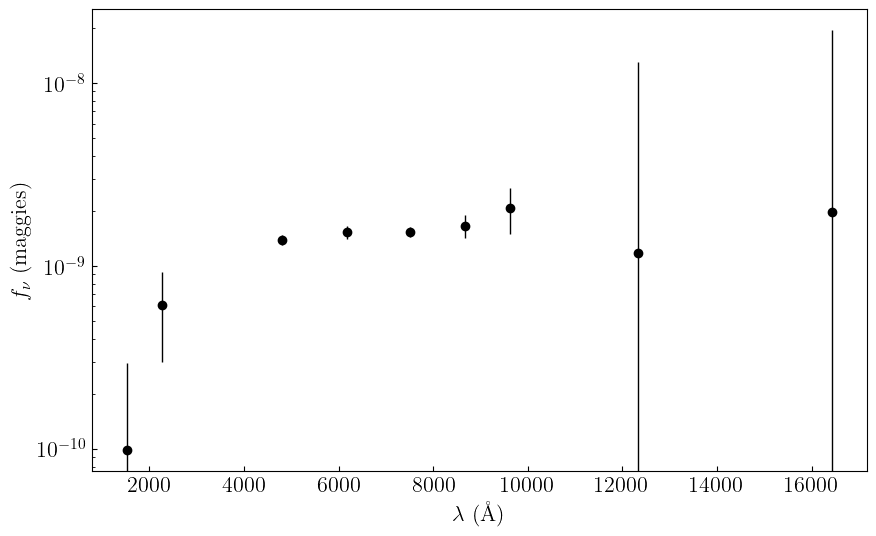

In [5]:
#Plotting settings (from Jimenez-Palau et al. 2022)
%matplotlib inline

rc('font', size=16)  
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rcParams['figure.figsize'] = 10, 6
plt.rc('grid', color='gray', linestyle=':')
plt.rc('xtick', direction='in', color='black')
plt.rc('ytick', direction='in', color='black')

plt.errorbar(obs["phot_wave"],  obs["maggies"], yerr=obs["maggies_unc"], color="k",linestyle="",linewidth=1,marker='o')
plt.yscale("log")
plt.ylabel(r"$f_\nu$ (maggies)")
plt.xlabel(r"$\lambda$ (\AA)")

## We build the model 
Then, the next step is to create the model to describe our stellar populations. Since PROSPECTOR uses a bayesian approach, this means that we need to add aproppiate initial values and priors per each science case.
This initial values will describe what we assume for the redshift, the ages of the stellar populations, and the Star Formation Rates.
In this case we will use a non-parametric (Star Formation History) SFH + the fixed value for the redshift. 
See https://prospect.readthedocs.io/en/latest/sfhs.html for more details.

In [6]:
from astropy.cosmology import WMAP9 as cosmo
model_params = TemplateLibrary["continuity_sfh"]
 #We fit the known redshift
    
    
model_params["zred"]['isfree'] = False
model_params["zred"]["init"] = z_obs
    
nbins_sfh=4
    
model_params["nbins_sfh"] = dict(N=1, isfree=False, init=nbins_sfh)
model_params['agebins']['N'] = nbins_sfh
model_params['mass']['N'] = nbins_sfh
model_params['logsfr_ratios']['N'] = nbins_sfh-1
model_params['logsfr_ratios']['init'] = np.full(nbins_sfh-1, 0.0)  # constant SFH
model_params['logsfr_ratios']['prior'] = priors.StudentT(mean=np.full(nbins_sfh-1, 0.0),
                                                         scale=np.full(nbins_sfh-1, 0.3),
                                                         df=np.full(nbins_sfh-1, 2))
               
 # add redshift scaling to agebins, such that t_max = t_univ
def zred_to_agebins(zred=None, nbins_sfh=None, **extras):
        tuniv = np.squeeze(cosmo.age(zred).to("yr").value)
        ncomp = np.squeeze(nbins_sfh)
        tbinmax = (tuniv*0.9)
        agelims = [0.0, 7.4772] + np.linspace(8.0, np.log10(tbinmax), ncomp-2).tolist() + [np.log10(tuniv)]
        agebins = np.array([agelims[:-1], agelims[1:]])
        return agebins.T

def logmass_to_masses(logmass=None, logsfr_ratios=None, zred=None, **extras):
    agebins = zred_to_agebins(zred=zred, **extras)
    logsfr_ratios = np.clip(logsfr_ratios, -10, 10)  # numerical issues...
    nbins = agebins.shape[0]
    sratios = 10**logsfr_ratios
    dt = (10**agebins[:, 1] - 10**agebins[:, 0])
    coeffs = np.array([(1./np.prod(sratios[:i])) * (np.prod(dt[1:i+1]) / np.prod(dt[:i])) for i in range(nbins)])
    m1 = (10**logmass) / coeffs.sum()
    return m1 * coeffs

model_params['agebins']['depends_on'] = zred_to_agebins
model_params['mass']['depends_on'] = logmass_to_masses

  # --- metallicity (flat prior) ---
model_params["logzsol"]["prior"] = priors.TopHat(mini=-1.0, maxi=0.19)

  # --- complexify the dust ---
model_params['dust_type']['init'] = 4
model_params["dust2"]["prior"] = priors.ClippedNormal(mini=0.0, maxi=2.0, mean=0.3, sigma=1)
model_params["dust_index"] = dict(N=1, isfree=True, init=0,
                                        prior=priors.TopHat(mini=-1.0, maxi=0.2))

def to_dust1(dust1_fraction=None, dust1=None, dust2=None, **extras):
      return dust1_fraction*dust2

model_params['dust1'] = dict(N=1, isfree=False, init=0,
                                   prior=None, depends_on=to_dust1)
model_params['dust1_fraction'] = dict(N=1, isfree=True, init=1.0,prior=priors.ClippedNormal(mini=0.0, maxi=2.0, mean=1.0, sigma=0.3))

model_params.update(TemplateLibrary['nebular_marginalization'])
model_params.update(TemplateLibrary['fit_eline_redshift'])
model_params['eline_prior_width']['init'] = 1.0
model_params['use_eline_prior']['init'] = True

# only marginalize over a few (strong) emission lines
# The allowed names of the emission lines are in $SPS_HOME/data/emlines_info.dat
#         
#to_fit = ['H delta 4102', 'H gamma 4340', '[OIII]4364', 'HeI 4472','H beta 4861','[OIII]4960','[OIII]5007','[ArIII]5193',
#                           '[NII]6549','H alpha 6563','[NII]6585','[SII]6717','[SII]6732']
#model_params['lines_to_fit']['init'] = to_fit

#             # model_params['use_eline_prior']['init'] = False
model_params['nebemlineinspec']['init'] = True
model_params.update(TemplateLibrary["dust_emission"])

#model_params['duste_gamma'] = {'N':1, 'isfree':False, 'init':0.01}
#model_params['duste_umin'] = {'N':1, 'isfree':False, 'init':1.0}
#model_params['duste_qpah'] = {'N':1, 'isfree':False, 'init':2.0}

#We store all the initial fixed values and priors and build the model
model=SpecModel(model_params)   
print(model)

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-1.0,maxi=0.19)
  dust2: <class 'prospect.models.priors.ClippedNormal'>(mean=0.3,sigma=1,mini=0.0,maxi=2.0)
  logmass: <class 'prospect.models.priors.TopHat'>(mini=7,maxi=12)
  logsfr_ratios: <class 'prospect.models.priors.StudentT'>(mean=[0. 0. 0.],scale=[0.3 0.3 0.3],df=[2 2 2])
  dust_index: <class 'prospect.models.priors.TopHat'>(mini=-1.0,maxi=0.2)
  dust1_fraction: <class 'prospect.models.priors.ClippedNormal'>(mean=1.0,sigma=0.3,mini=0.0,maxi=2.0)
  eline_sigma: <class 'prospect.models.priors.TopHat'>(mini=30,maxi=300)
  eline_delta_zred: <class 'prospect.models.priors.TopHat'>(mini=-0.01,maxi=0.01)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.02363] 
  mass: [1000000.] <function logmass_to_masses at 0x7f8c1cb09d30>
  sfh: [3] 
  imf_type: [2] 
  dust_type: [4] 
  agebins: [[ 0.  8.]
 [ 8.  9.]
 [ 9. 

## Get the source: Stellar Population Synthesis
Then to properly model the SED we will need a "source" to use to fit the photometry using Stellar Synthesis Population. The choice of the model is dependent of the SFH that we selected.
For this case we will use one that is suitable for non-parametric SFH: FastStepBasis

In [8]:
sps = FastStepBasis(zcontinuous=1)

## Adding the noise
We add the noise to the model to make it more realistic. This can be done in different ways. In this case a simple gaussian noise is adopted.

In [9]:
noise_model = (None, None)

## We view the model

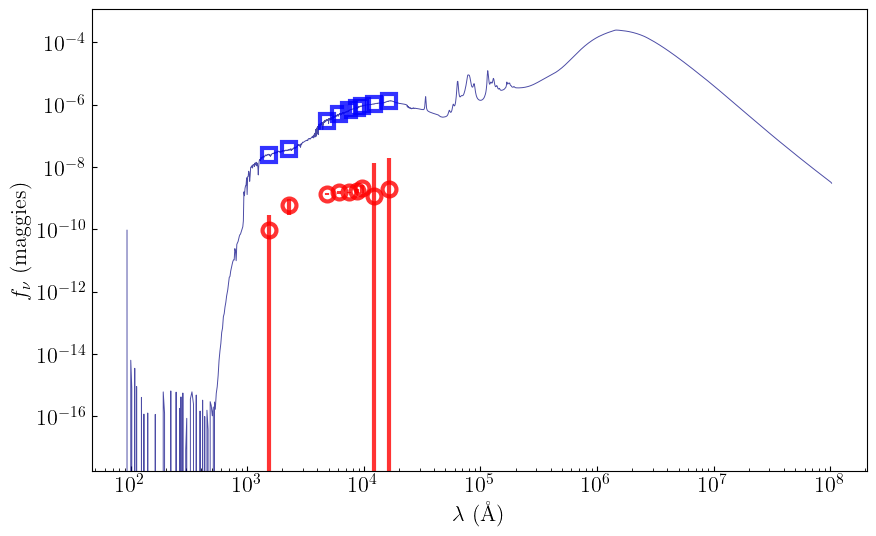

In [10]:
# Generate the model SED at the initial value of theta
theta = model.theta.copy()
initial_spec, initial_phot, initial_mfrac = model.predict(theta, obs=obs, sps=sps)
title_text = ','.join(["{}={}".format(p, model.params[p][0]) 
                       for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
# photometric effective wavelengths
wphot = obs["phot_wave"]
# spectroscopic wavelengths
if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths
    wspec *= a #redshift them
else:
    wspec = obs["wavelength"]
    
rc('font', size=16)  
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rcParams['figure.figsize'] = 10, 6
plt.rc('grid', color='gray', linestyle=':')
plt.rc('xtick', direction='in', color='black')
plt.rc('ytick', direction='in', color='black')
    
plt.loglog(wspec, initial_spec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
plt.errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)
plt.ylabel(r"$f_\nu$ (maggies)")
plt.xlabel(r"$\lambda$ (\AA)")
plt.savefig(path+target+'_'+analysis+'_'+ap+'arcsec_emcee_model.pdf', format='pdf')
    


## Get the first guess: Minimization

In [14]:
# --- start minimization ----
run_params={}
run_params["dynesty"] = False
run_params["emcee"] = False 
run_params["optimize"] = True
run_params["min_method"] = 'lm'
# We'll start minimization from "nmin" separate places, 
# the first based on the current values of each parameter and the 
# rest drawn from the prior.  Starting from these extra draws 
# can guard against local minima, or problems caused by 
# starting at the edge of a prior (e.g. dust2=0.0)
run_params["nmin"] = 8
try: 
    output = fit_model(obs, model, sps, lnprobfn=lnprobfn,noise=noise_model, **run_params)
    print("Done optimization in {}s".format(output["optimization"][1]))
except ValueError:
    run_params={}
    print('Not enough photometry values to run optimization')

minimizer: Exception while trying to minimize the function:
  params: [ -0.5   0.6  10.    0.    0.    0.    0.    1.  100.    0. ]
  args: ()
  exception:
Not enough photometry values to run optimization


Traceback (most recent call last):
  File "/Users/cristinajimenezpalau/anaconda3/envs/prospector2/lib/python3.8/site-packages/prospect/fitting/minimizer.py", line 22, in __call__
    return self.f(self.func, x, args=self.args,
  File "/Users/cristinajimenezpalau/anaconda3/envs/prospector2/lib/python3.8/site-packages/scipy/optimize/_lsq/least_squares.py", line 843, in least_squares
    raise ValueError("Method 'lm' doesn't work when the number of "
ValueError: Method 'lm' doesn't work when the number of residuals is less than the number of variables.


## View optimization results

In [15]:
try:
    print(model.theta)
    (results, topt) = output["optimization"]
    # Find which of the minimizations gave the best result, 
    # and use the parameter vector for that minimization
    ind_best = np.argmin([r.cost for r in results])
    print(ind_best)
    theta_best = results[ind_best].x.copy()
    print(theta_best)

    # generate model
    prediction = model.mean_model(theta_best, obs=obs, sps=sps)
    pspec, pphot, pfrac = prediction

    plt.figure(figsize=(16,8))

    # plot Data, best fit model, and old models
    plt.loglog(wspec, initial_spec, label='Old model spectrum',
           lw=0.7, color='gray', alpha=0.5)
    plt.errorbar(wphot, initial_phot, label='Old model Photometry', 
             marker='s', markersize=10, alpha=0.6, ls='', lw=3, 
             markerfacecolor='none', markeredgecolor='gray', 
             markeredgewidth=3)
    plt.loglog(wspec, pspec, label='Model spectrum', 
           lw=0.7, color='slateblue', alpha=0.7)
    plt.errorbar(wphot, pphot, label='Model photometry', 
             marker='s', markersize=10, alpha=0.8, ls='', lw=3,
             markerfacecolor='none', markeredgecolor='slateblue', 
             markeredgewidth=3)
    plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
             label='Observed photometry', 
             marker='o', markersize=10, alpha=0.8, ls='', lw=3, 
             ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
             markeredgewidth=3)

    plt.ylabel(r"$f_\nu$ (maggies)")
    plt.xlabel(r"$\lambda$ (\AA)")
    plt.xlim(5e2,1e6)
    plt.savefig(path+target+'_'+analysis+'_'+ap+'arcsec_emcee_optimization.pdf', format='pdf')
except NameError:
    print('No optimization performed!')

[ -0.5   0.6  10.    0.    0.    0.    0.    1.  100.    0. ]
No optimization performed!


## Run the fit
Then we will proceed to the fit. We can use optimize, dynesty or emcee. 
In this case we will be using emcee. You can read more about it here: https://emcee.readthedocs.io/en/stable/
WARNING: It will take a while.

In [16]:
# Set this to False if you don't want to do another optimization
# before emcee sampling (but note that the "optimization" entry 
# in the output dictionary will be (None, 0.) in this case)
# If set to true then another round of optmization will be performed 
# before sampling begins and the "optmization" entry of the output
# will be populated.
run_params["optimize"] = False
run_params["emcee"] = True
run_params["dynesty"] = False
# Number of emcee walkers
run_params["nwalkers"] = 128
# Number of iterations of the MCMC sampling
run_params["niter"] = 1024
# Number of iterations in each round of burn-in
# After each round, the walkers are reinitialized based on the 
# locations of the highest probablity half of the walkers.
run_params["nburn"] = [16, 32, 64]

output = fit_model(obs, model, sps, lnprobfn=lnprobfn, noise=noise_model, **run_params)

print('done emcee in {0}s'.format(output["sampling"][1]))

number of walkers=128


/Users/cristinajimenezpalau/anaconda3/envs/prospector2/lib/python3.8/site-packages/prospect/models/priors.py:117: RuntimeWarning: divide by zero encountered in log
  lnp = np.log(p)


done burn #0 (16 iterations)
done burn #1 (32 iterations)
done burn #2 (64 iterations)
number of walkers=128
starting production
done production
done emcee in 7060.652569293976s


In [18]:
from prospect.io import write_results as writer
fit_type='emcee'
hfile = path+target+"_"+fit_type+"_dust_mcmc.h5"
writer.write_hdf5(hfile, run_params, model, obs,
                 output["sampling"][0], output["optimization"][0],
                 sps=sps,
                 tsample=output["sampling"][1],
                 toptimize=output["optimization"][1])

Appending current time (24Apr09-10.56) to output file in order to guarantee a unique name.
New output filename: /Users/cristinajimenezpalau/Desktop/Super-Chandra/images/SN2006gz/SN2006gz_emcee_dust_mcmc_24Apr09-10.56.h5


/Users/cristinajimenezpalau/anaconda3/envs/prospector2/lib/python3.8/site-packages/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
  warnings.warn("Could not store paramfile text", RuntimeWarning)
/Users/cristinajimenezpalau/anaconda3/envs/prospector2/lib/python3.8/site-packages/prospect/io/write_results.py:290: RuntimeWarning: Could not JSON serialize model_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),
/Users/cristinajimenezpalau/anaconda3/envs/prospector2/lib/python3.8/site-packages/prospect/io/write_results.py:49: RuntimeWarning: Could not obtain prospector version info
  warnings.warn("Could not obtain prospector version info", RuntimeWarning)


## We read the file 
We use Prospector libraries to read the written file with the obtained results. The out dictionary gives information about the fitting parameters and weights, out_obs contains the input values (the observed photometry) and out_model the model values: modeled photometry and SED. 

In [19]:
import prospect.io.read_results as reader
results_type = "emcee"

out, out_obs,out_model = reader.results_from(path+target+"_"+fit_type+"_dust_mcmc.h5".format(results_type))
print(out_model)
    

None


## Plotting the results

[-0.85009567  0.57882086  0.03254344  0.08302553  0.78440207  0.35650276
 -0.87365146 -0.18868888  0.50090532]


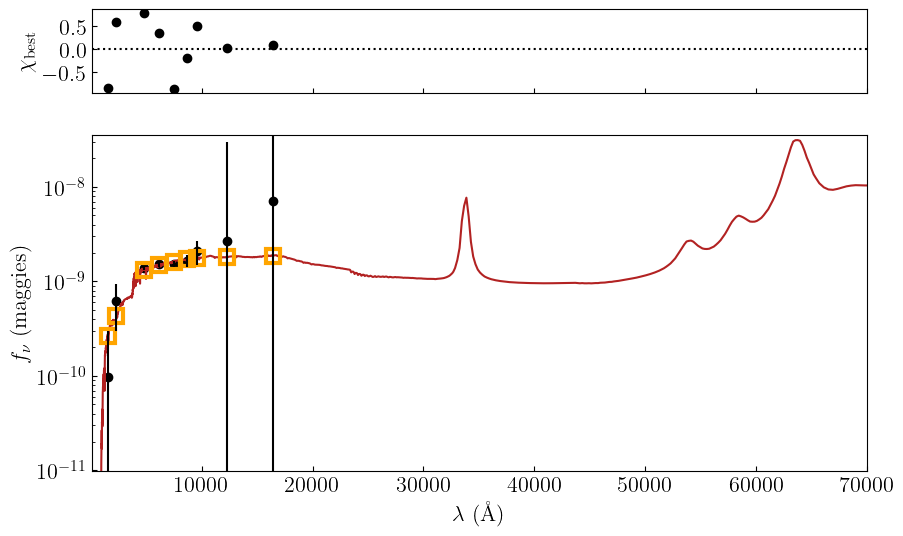

In [20]:
#Plotting settings (from Jimenez-Palau et al. 2022)
%matplotlib inline

rc('font', size=16)  
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rcParams['figure.figsize'] = 10, 6
plt.rc('grid', color='gray', linestyle=':')
plt.rc('xtick', direction='in', color='black')
plt.rc('ytick', direction='in', color='black')



import matplotlib.pyplot as plt
sfig, saxes = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[1, 4]), sharex=True)
ax = saxes[1]
pwave = out_obs["phot_wave"]
# plot the data
ax.plot(pwave, out_obs["maggies"], linestyle="", marker="o", color="k")
ax.errorbar(pwave,  out_obs["maggies"], out_obs["maggies_unc"], linestyle="", color="k", zorder=10)
ax.set_ylabel(r"$f_\nu$ (maggies)")
ax.set_xlabel(r"$\lambda$ (\AA)")
ax.set_xlim(9e1, 7e4)
ax.set_ylim(out_obs["maggies"].min() * 0.1, out_obs["maggies"].max() * 5)
ax.set_yscale("log")

# get the best-fit SED
bsed = out["bestfit"]
ax.plot(bsed["restframe_wavelengths"] * (1+out_obs["redshift"]), bsed["spectrum"], color="firebrick", label="MAP sample")
ax.plot(pwave, bsed["photometry"], linestyle="", marker="s", markersize=10, mec="orange", mew=3, mfc="none")

ax = saxes[0]
chi = (out_obs["maggies"] - bsed["photometry"]) / out_obs["maggies_unc"]
print(chi)
ax.plot(pwave, chi, linestyle="", marker="o", color="k")
ax.axhline(0, color="k", linestyle=":")
ax.set_ylabel(r"$\chi_{\rm best}$")
plt.savefig(path+target+'_'+analysis+'_'+ap+'arcsec_emcee_bestfitSED.pdf', format='pdf')

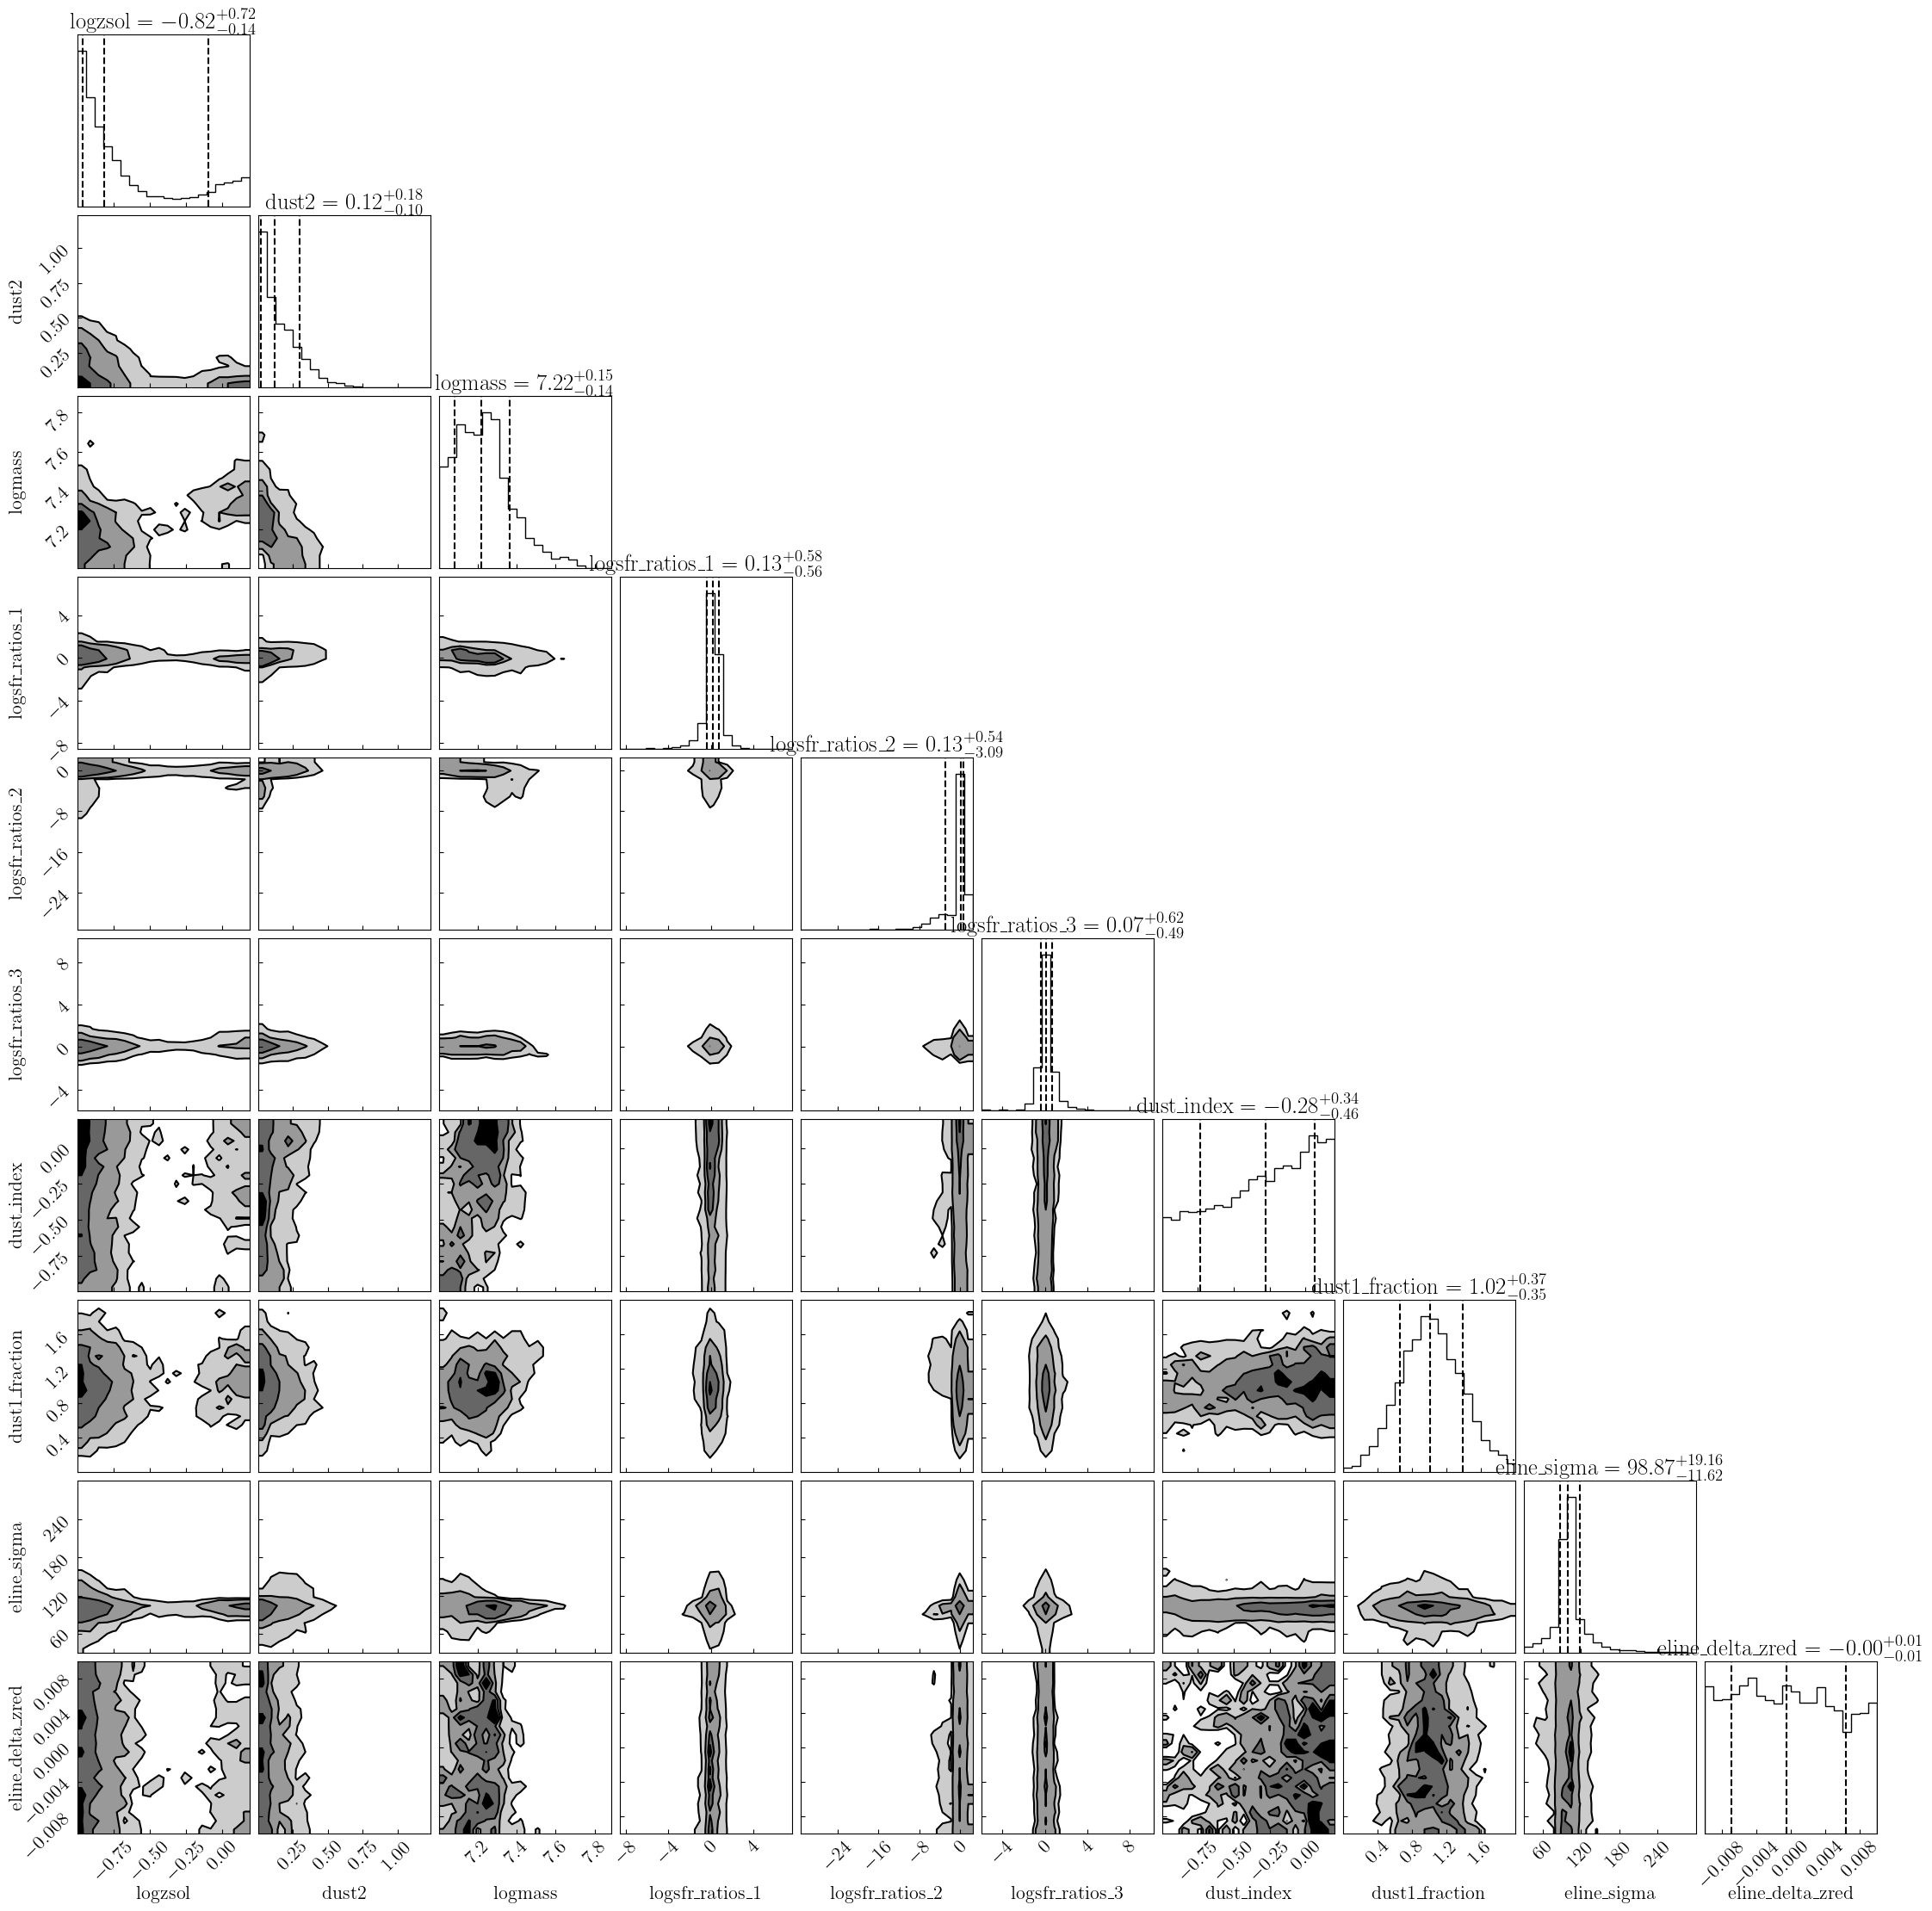

In [21]:
import corner


# Corner figure of posterior PDFs
cfig = reader.subcorner(out)
plt.savefig(path+target+'_'+analysis+'_'+ap+'arcsec_emcee_cornerplot.pdf', format='pdf')

## Read the outputs

We read the outputs and we obtain the stellar populations parameters that we're interested on.

In [23]:
import prospect.io.read_results as reader

print('The results for the best fit are',out['bestfit'])


The results for the best fit are {'parameter': array([-9.28260464e-01,  1.68156727e-01,  7.02499970e+00, -1.53612391e-02,
        8.90142304e-01, -1.16389691e-01, -9.49061216e-01,  1.04943826e+00,
        1.09097269e+02,  5.78784077e-03]), 'photometry': array([2.66036536e-10, 4.30795017e-10, 1.81757556e-09, 1.84828171e-09,
       1.32527307e-09, 1.48307668e-09, 1.61843099e-09, 1.70901595e-09,
       1.79006932e-09]), 'restframe_wavelengths': array([9.100e+01, 9.400e+01, 9.600e+01, ..., 9.817e+07, 9.908e+07,
       1.000e+08]), 'spectrum': array([ 5.34131281e-13, -5.96274518e-16, -1.00551959e-17, ...,
        1.87916531e-11,  1.82957182e-11,  1.72860238e-11]), 'mfrac': 0.6185620301670828}
